In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

# Preparation & intialisation

In [2]:
# load training images & the ground truth masks

train_colour_files = glob.glob("apples/Train_*.jpg")
TrainColourImgs = []
for colour_file in train_colour_files:
    im = plt.imread(colour_file)
    TrainColourImgs.append(im)

train_mask_files = glob.glob("imageMasks/Train_*.png")
TrainMaskImgs = []
for mask_file in train_mask_files:
    im = plt.imread(mask_file)
    TrainMaskImgs.append(im)

In [3]:
# load test images & ground truth masks 
test_colour_files_without_groundtruth = glob.glob("apples/Test_without_groundtruth*.jpg")
TestWithoutGroundTruthColourImgs = []
for colour_file in test_colour_files_without_groundtruth:
    im = plt.imread(colour_file)
    TestWithoutGroundTruthColourImgs.append(im)

test_colour_files_with_groundtruth = glob.glob("apples/Test_with_groundtruth*.jpg")
TestWithGroundTruthColourImgs = []
for colour_file in test_colour_files_with_groundtruth:
    im = plt.imread(colour_file)
    TestWithGroundTruthColourImgs.append(im)

test_mask_files = glob.glob("imageMasks/Test_with_groundtruth_*.png")
TestWithGroundTruthMaskImgs = []
for mask_file in test_mask_files:
    im = plt.imread(mask_file)
    TestWithGroundTruthMaskImgs.append(im)

In [4]:
# load custom test images & ground truth masks

test_colour_files_my_own = glob.glob("apples/Test_my_image_*.jpg")
TestMyColourImgs = []
for colour_file in test_colour_files_my_own:
    im = plt.imread(colour_file)
    TestMyColourImgs.append(im)

test_mask_files_my_own = glob.glob("imageMasks/Test_my_image_*.png")
TestMyMaskImgs = []
for mask_file in test_mask_files_my_own:
    im = plt.imread(mask_file)
    TestMyMaskImgs.append(im)

First, we have a look at the apple images for training

Training Image 1


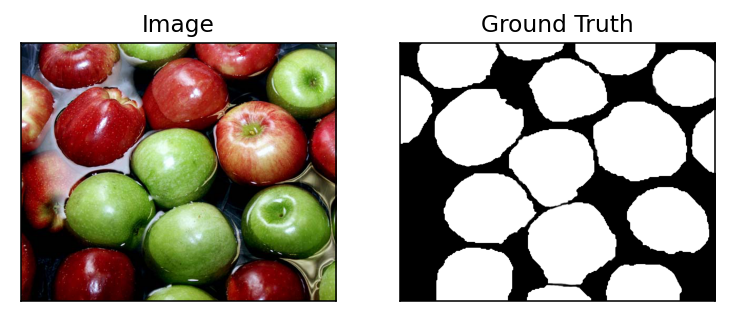

Training Image 2


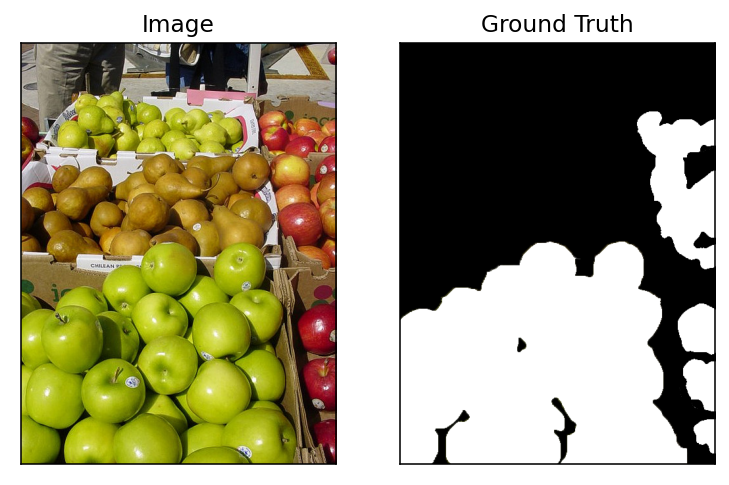

Training Image 3


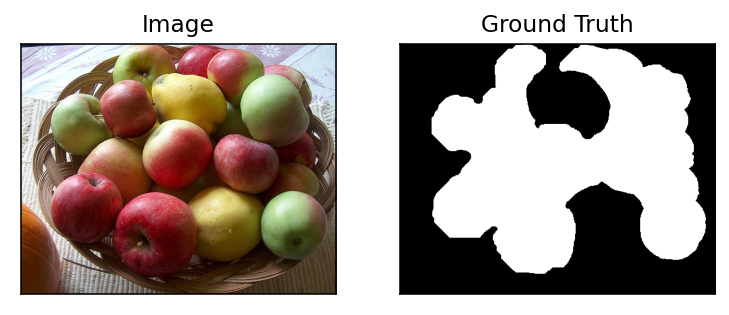

In [5]:
# show the apple images for training and the respective mask images
for i in range(len(TrainColourImgs)):
    
    print(f'Training Image {i+1}')

    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_dpi(140)
    ax1.set_title('Image')
    ax2.set_title('Ground Truth')
    ax1.imshow(TrainColourImgs[i])
    ax2.imshow(TrainMaskImgs[i])

    # hide tick marks from the plots
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax2.set_yticks([])
    ax2.set_xticks([])

    plt.show()

# Define helper functions

In this section, I defined some helper functions for pre-processing, data set generation, log probability calculation and fitting of mixtures of Gaussian models.

### Helper Functions -  Re-formatting / pre-processing of the image data

In [6]:
# Helper function: flatten the image and transform it into [3, total number of pixels] matrix
def preprocess_image(image):
    colours = []
    for c in range (image.shape[2]):
        colours.append(image[:,:,c].flatten())
    return np.float32(np.array(colours))

# Helper function: flatten the mask image and transform it into [3, total number of pixels] matrix. In case that the RGB of the pixels has value other than {1,0}, I take the average of the R,G,B components and round it up.
def preprocess_mask(mask):
    classification = []
    for pixel in preprocess_image(mask).T:
        if sum(pixel)/len(pixel) >= 0.5:
            y = 1
        else:
            y = 0
        classification.append(y)
    return np.array(classification)

def recover_image_shape(pixels, origImg):
    ix, iy, iz = origImg.shape
    r = pixels[0].reshape((ix,iy,1))
    g = pixels[1].reshape((ix,iy,1))
    b = pixels[2].reshape((ix,iy,1))
    return np.concatenate((r,g,b),axis=2)

### Helper Function -  Generate training data sets

In [7]:
# Helper function: this function will format and concatenate the training data into the appropriate data format, it also splits the data set into 2 groups (apple vs non-apple) based on the respective ground truth mask images
def generateTrainingDataSets(trainImgs, MaskImgs):
    trainApple = np.concatenate(([((preprocess_image(trainImgs[i]).T)[preprocess_mask(MaskImgs[i])==1]).T for i in range(len(trainImgs))]), axis=1)
    trainNonApple = np.concatenate(([((preprocess_image(trainImgs[i]).T)[preprocess_mask(MaskImgs[i])==0]).T for i in range(len(trainImgs))]), axis=1)
    return trainApple, trainNonApple

### Helper Functions -  Calculate log probability and log likelihood of from the MixGauss

In [8]:
# Helper function: calculate the multivariate normal distribution log probability (and it supports multiple data points X)
def getGaussLogProb(X, mean, cov):

    nDims = X.shape[0] 
    if X.ndim == 1:
        X_reshaped = X.reshape((nDims, 1))
    else:
        X_reshaped = X
    if mean.ndim == 1:
        mean_reshaped = mean.reshape((mean.shape[0], 1))
    else:
        mean_reshaped = mean
    
    X_minus_mean = X_reshaped - mean_reshaped
    cov_inv, cov_det = np.linalg.inv(cov), np.linalg.det(cov)

    return -(nDims/2)*np.log(2*np.pi)-0.5*np.log(cov_det)-0.5*np.sum((np.matmul(X_minus_mean.T, cov_inv)*(X_minus_mean.T)), axis=1)


In [9]:
def getMixGaussLogLike(data, mixGaussEst): 
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log probability                                                                         
    logProb = np.zeros((mixGaussEst["k"], nData))

    for k in range(mixGaussEst["k"]):
        mean = mixGaussEst["mean"][:,k]
        cov = mixGaussEst["cov"][:,:,k]
        logProb[k,:] = getGaussLogProb(data, mean, cov)

    # add respective log(weigh_k) into the log prob (according to k)
    logProb = logProb + np.log(mixGaussEst["weight"][:,None])

    # add up the log prob (with log(weight)) of each hidden layer using log-add-exp for each X,
    # then sum up all results for each X
    logProb = np.sum(np.logaddexp.reduce(logProb,axis=0))
    return logProb

### Helper Function - Fit data to the MixGauss model

The model fitting will run as many iterations as needed subject to the following stopping conditions:
1. It reaches the maximum number of iterations - capped as 1000 (so it won't run forever it doesn't converge)
2. The logLike is not improving in the last 10 consecutive iterations (convergence occurs)

Since our models will randomly pick some starting parameters (e.g. mean, cov), it is possible to go into unexpected error (for example, getting Singular matrix for cov). The algorithm that I implemented includes a retry mechanism in case of such error.

In [10]:
def fitMixGauss(data, k):
    """
    Estimate a k MoG model that would fit the data.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape

    postHidden = np.zeros(shape=(k, nData))

    # we will initialize the values to random values
    mixGaussEst = dict()
    mixGaussEst['d'] = nDims
    mixGaussEst['k'] = k
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))
    mixGaussEst['mean'] = 2 * np.random.randn(nDims, k)
    mixGaussEst['cov'] = np.zeros(shape=(nDims, nDims, k))
    for cGauss in range(k):
        mixGaussEst['cov'][:, :, cGauss] = 2.5 + 1.5 * np.random.uniform() * np.eye(nDims)
        
    # calculate current likelihood
    logLike = getMixGaussLogLike(data, mixGaussEst)
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))

    previousLogLike = np.array([])

    MAX_ITERS = 1000
    cIter = 0

    # define the stopping condition: 1) iteration # > MAX_ITERS, or 2)  the logLike is not improving in the last 10 consecutive iterations
    while cIter < 1000 and not (len(previousLogLike)>10 and (np.round(previousLogLike[-10:], 3) == np.round(previousLogLike[-1], 3)).all()) :

        # ===================== =====================
        # Expectation step
        # ===================== =====================

  
        logProb = np.zeros((mixGaussEst['k'], nData))
        for cGauss in range(mixGaussEst['k']):
            mean = mixGaussEst['mean'][:,cGauss]
            cov = mixGaussEst['cov'][:,:,cGauss]
            logProb[cGauss,:] = getGaussLogProb(data, mean, cov)

        weightedProb = np.exp(logProb) * mixGaussEst["weight"][:,None]
        postHidden = np.divide(weightedProb,np.sum(weightedProb, axis = 0) ,out=np.zeros_like(weightedProb), where=np.sum(weightedProb, axis = 0)!=0)
   
        # ===================== =====================
        # Maximization Step
        # ===================== =====================

        # Update weighting parameters mixGauss.weight based on the total posterior probability associated with each Gaussian.
        mixGaussEst['weight'] = np.sum(postHidden, axis=1)/np.sum(postHidden)
        
        # Update mean parameters mixGauss.mean by weighted average where weights are given by posterior probability associated with Gaussian.
        mixGaussEst['mean'] = (np.divide(postHidden @ (data.T),np.sum(postHidden, axis=1)[:,None])).T

        for cGauss in range(k):
            
            # Update covarance parameter based on weighted average of square distance from update mean, where weights are given by posterior probability associated with Gaussian
            mixGaussEst['cov'][:,:,cGauss] = np.matmul(postHidden[cGauss,:]*(data-mixGaussEst['mean'][:,cGauss,None]),(data-mixGaussEst['mean'][:,cGauss,None]).T)/np.sum(postHidden[cGauss,:])

        # calculate the log likelihood
        logLike = getMixGaussLogLike(data, mixGaussEst)
        print('Log Likelihood After Iter {} : {:4.3f}\n'.format(cIter, logLike))

        previousLogLike =np.append(previousLogLike, logLike)
        cIter += 1

    return mixGaussEst

### Helper Functions - calculate posterior and display /plot results

In [11]:
def getPosteriorApple(image, priorApple, priorNonApple, mixGaussEstApple, mixGaussEstNonApple):
    
    imY, imX, imZ = image.shape
    reshapedImg = preprocess_image(image)

    likeApple = np.sum([mixGaussEstApple['weight'][cGauss]*np.exp(getGaussLogProb(reshapedImg/255, mixGaussEstApple['mean'][:,cGauss], mixGaussEstApple['cov'][:,:,cGauss])) for cGauss in range(mixGaussEstApple['k'])], axis=0)
    likeNonApple = np.sum([mixGaussEstNonApple['weight'][cGauss]*np.exp(getGaussLogProb(reshapedImg/255, mixGaussEstNonApple['mean'][:,cGauss], mixGaussEstNonApple['cov'][:,:,cGauss])) for cGauss in range(mixGaussEstNonApple['k'])], axis=0)

    posteriorApple = np.zeros_like(likeApple)
    for p in range(len(likeApple)):
        posteriorApple[p] = likeApple[p]*priorApple/(likeApple[p]*priorApple+likeNonApple[p]*priorNonApple)

    return np.squeeze(posteriorApple.reshape((imY, imX,1)))


In [12]:
def predict_and_show_result(image, maskImage, priorApple, priorNonApple, mixGaussEstApple, mixGaussEstNonApple):

    posteriorApple = getPosteriorApple(image, priorApple, priorNonApple, mixGaussEstApple, mixGaussEstNonApple)

    # set up plots
    if str(type(maskImage)) =="<class 'numpy.ndarray'>":
        f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    else:
        f, (ax1, ax3) = plt.subplots(1, 2)

    f.set_dpi(140)

    #show the image
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.set_yticks([])
    ax1.set_xticks([])

    if str(type(maskImage)) =="<class 'numpy.ndarray'>":
        #show our groundtruth
        ax2.imshow(maskImage)
        ax2.set_title('Groundtruth')
        ax2.set_yticks([])
        ax2.set_xticks([])

    #show our prediction!
    ax3.imshow(posteriorApple)
    ax3.set_title('Result')
    ax3.set_yticks([])
    ax3.set_xticks([])

    plt.show()

    return posteriorApple


In [13]:
#Helper Function - plot ROC curve
def plot_ROC_curve(posterior, maskImg):

    # get the ground truth classification from mask image
    groundtruth_classification = preprocess_mask(maskImg)

    # flatten the posterior matrix into an 1-d array
    posterior_flatten = posterior.flatten()

    # define a list of thresholds between 0 and 1
    thresholds = np.arange(0.0, 1.01, 0.01)

    # initialise variables: truePositiveRate, falsePositiveRate
    truePositiveRate = []
    falsePositiveRate = []

    for threshold in thresholds:
        TP = np.sum(groundtruth_classification[posterior_flatten>=threshold] == 1)
        FP = np.sum(groundtruth_classification[posterior_flatten>=threshold] == 0)
        TN = np.sum(groundtruth_classification[posterior_flatten<threshold] == 0)
        FN = np.sum(groundtruth_classification[posterior_flatten<threshold] == 1) 
        truePositiveRate.append(TP/(TP+FN))
        falsePositiveRate.append(FP/(FP+TN))

    f, ax = plt.subplots()
    ax.set_title("ROC Curve")
    ax.set_xlabel("False Positve Rate")
    ax.set_ylabel("True Positve Rate")
    ax.plot(falsePositiveRate, truePositiveRate, label='Our mixtures of Gaussians classifier')
    ax.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), linestyle='dashed', color='gray', label='Random classifier (baseline)')
    ax.legend()
    
    plt.show()

# Fitting the models

In order to fit the models in a way such that they can predict whether a pixel is similar to apple or non-apple, I used the 3 images above for training purpose. 

I split the training sets into two: trainApple and trainNonApple, according to the binary classification from the resepctive ground-truth masks of the training images.

Additionally, I also normalised the three dimensions (i.e. r, g, b) of a pxiel to be bound by $[0,1]$ for easier computation.

In [14]:
# generate training sets
trainApple, trainNonApple = generateTrainingDataSets(TrainColourImgs, TrainMaskImgs)

# normalise the training data to be in range between 0 to 1
trainApple = trainApple/255
trainNonApple = trainNonApple/255

# fit the models for Apple and Non-Apple separately
mixGaussEstApple = fitMixGauss(trainApple, k=4)
mixGaussEstNonApple = fitMixGauss(trainNonApple, k=4)

Log Likelihood Iter 0 : -2713296.758

Log Likelihood After Iter 0 : 285403.250

Log Likelihood After Iter 1 : 294307.173

Log Likelihood After Iter 2 : 323025.923

Log Likelihood After Iter 3 : 370039.550

Log Likelihood After Iter 4 : 437546.867

Log Likelihood After Iter 5 : 528387.078

Log Likelihood After Iter 6 : 601487.630

Log Likelihood After Iter 7 : 650420.660

Log Likelihood After Iter 8 : 693005.804

Log Likelihood After Iter 9 : 745168.403

Log Likelihood After Iter 10 : 783726.929

Log Likelihood After Iter 11 : 799012.544

Log Likelihood After Iter 12 : 807109.889

Log Likelihood After Iter 13 : 812420.851

Log Likelihood After Iter 14 : 816354.893

Log Likelihood After Iter 15 : 819440.694

Log Likelihood After Iter 16 : 821882.887

Log Likelihood After Iter 17 : 823804.868

Log Likelihood After Iter 18 : 825286.160

Log Likelihood After Iter 19 : 826436.452

Log Likelihood After Iter 20 : 827338.811

Log Likelihood After Iter 21 : 828050.331

Log Likelihood After Iter 

# Checking the models with training images

Before we run any prediction, we will need to define the priors for apple and non-apple.

I have defined a smaller prior for apple and higher prior for non-apple because I wanted to be conservative in classifying a pixel as apple (as stated in the question).

Though with more data points used to fit the models, the importance of the prior should eventually be outweighed.

In [15]:
# let's define priors for whether the pixel is apple or non apple
PRIOR_APPLE = 0.4
PRIOR_NON_APPLE = 0.7

Now that our MixGauss model is fitted, let's test it with our training images.

Training Image 1


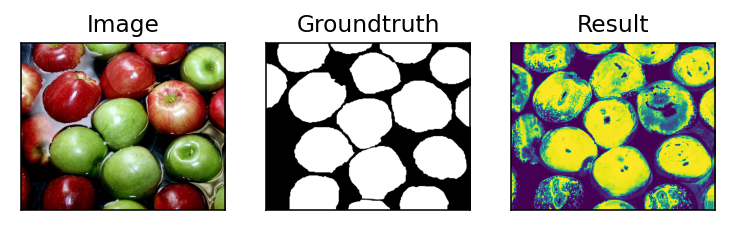

Training Image 2


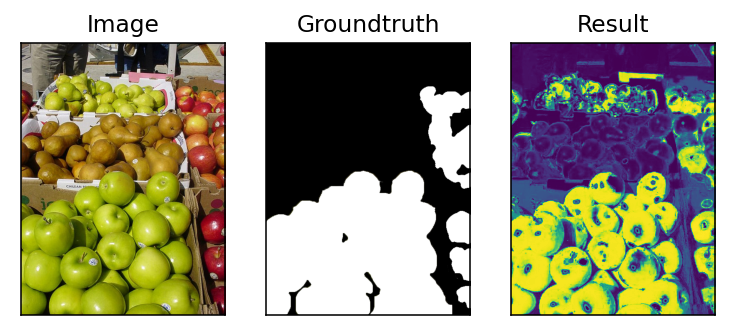

Training Image 3


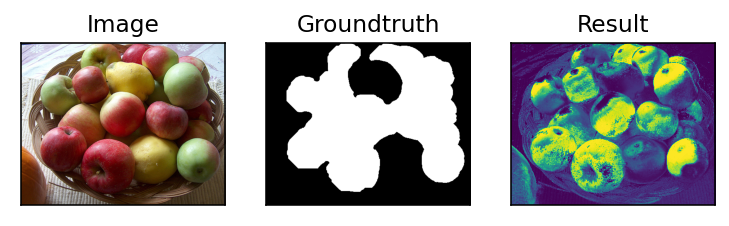

In [16]:
for i in range(len(TrainColourImgs)):
    print(f"Training Image {i+1}")
    predict_and_show_result(TrainColourImgs[i], TrainMaskImgs[i], PRIOR_APPLE, PRIOR_NON_APPLE, mixGaussEstApple, mixGaussEstNonApple)
    

The results look pretty good with pixels that the model was trained with. The higher posterior is shown in brigter colour in the result image, which corresponds quite closely with our ground truth masks in the middle.

# Testing with test images

I now test the models with two test images that are new to the MixGauss models.

Test Image 1


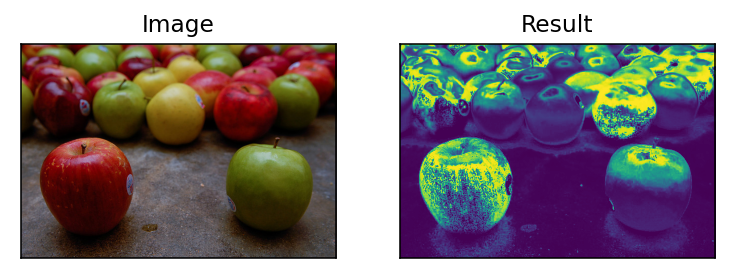

Test Image 2


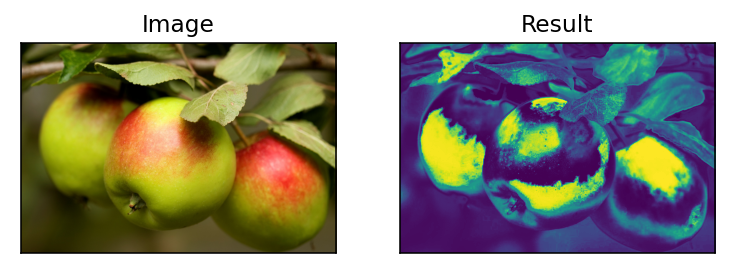

In [17]:
# run prediction for the 2 test images that do not come with the ground truth masks
for i in range(len(TestWithoutGroundTruthColourImgs)):
    print(f"Test Image {i+1}")
    predict_and_show_result(TestWithoutGroundTruthColourImgs[i], None, PRIOR_APPLE, PRIOR_NON_APPLE, mixGaussEstApple, mixGaussEstNonApple)

The results look generally good. We have high posterior for red apples, although we don't have very confident results for apples with green/light-coloured skin.

To better assess the model, let's now test with the test image with a ground truth mask.

One way to check how good is our classifier is to make use of the ROC curve.
When reading the ROC curve, we usually look at the Area Under the Curve (AUC), which is a measure of how well the classifier distinguishes between two classes. The greater the AUC is, the more capable a classifier is to be able to distinguish between classes well.

Test Image 3


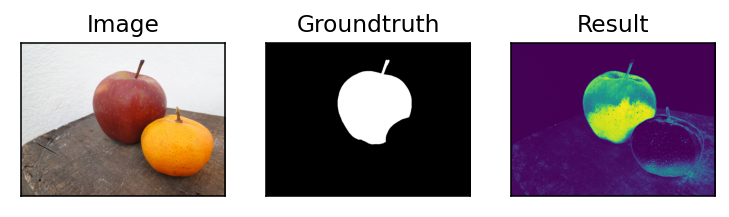

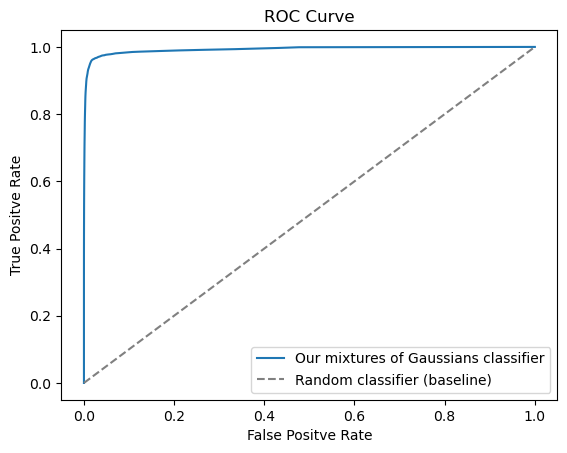

In [18]:
# Run prediction for the test image that does come with the ground truth masks
for i in range(len(TestWithGroundTruthColourImgs)):
    print(f"Test Image {i+1+len(TestWithoutGroundTruthColourImgs)}")
    posterior = predict_and_show_result(TestWithGroundTruthColourImgs[i], TestWithGroundTruthMaskImgs[i], PRIOR_APPLE, PRIOR_NON_APPLE, mixGaussEstApple, mixGaussEstNonApple)

    # plot the ROC curve
    plot_ROC_curve(posterior, TestWithGroundTruthMaskImgs[i])
    

The ROC curve plotted from our Test Image 3 produces an AUC very close to 1, which means that our Mixtures of Gaussians classifier is very good at distinguishing apple and non-apple pixels.



# Testing with my own images

Now, I will test the classifier further with 2 images of my own.

My Test Image 1


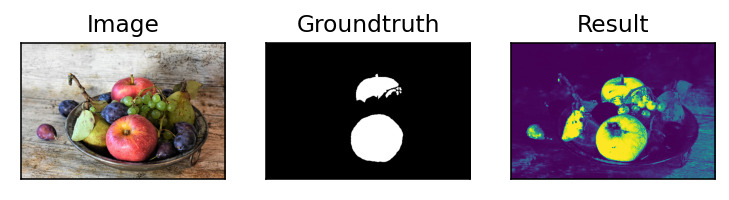

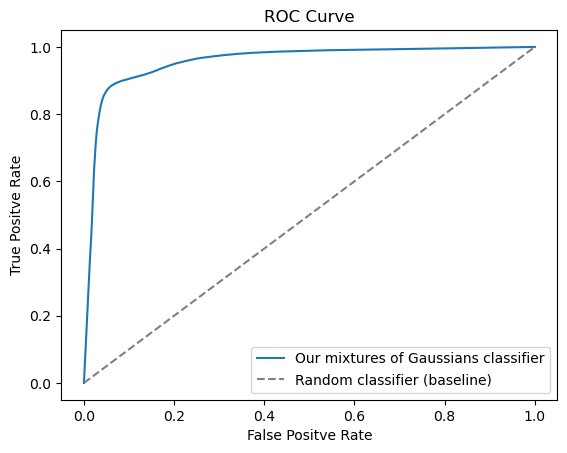

My Test Image 2


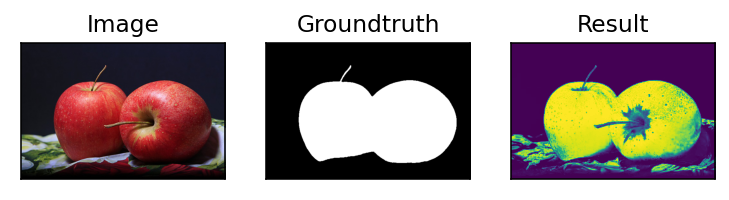

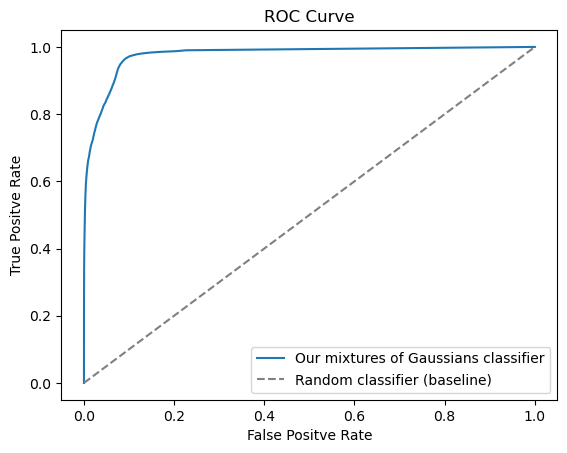

In [19]:
# Run prediction with my test images
for i in range(len(TestMyColourImgs)):
    print(f"My Test Image {i+1}")
    posterior = predict_and_show_result(TestMyColourImgs[i], TestMyMaskImgs[i], PRIOR_APPLE, PRIOR_NON_APPLE, mixGaussEstApple, mixGaussEstNonApple)

    # plot the ROC curve
    plot_ROC_curve(posterior, TestMyMaskImgs[i])

We observe some slightly different results from two images.

Firstly, on "My Test Image 1", our classifier has a lower true-positive rate.
Compared to the ROC curve we retrieve from the test image previously, the ROC curve of this image remains on the left side of the random classifier (baseline) in our plot. But the Area Under the Curve (AUC) is smaller, meaning that classifier could not distinguish as well as in the previous test image.
For example, we see from the result image that our classifier misclassifies the yellow-greenish colours of the skins of pears and grapes as apple.

Secondly, on "My Test Image 2", we still have the ROC curve of this image on the left side of the random classifier (baseline) in our plot. We do see there are some misclassification on the red petals in front of the apple, which results in higher false-positive rate.

Overall, our results show that our classifier performance depends very much on what other objects are in the image. It can be easily justified because when we trained the model. As we fed in the RGB of each pixel from the training images independently. Our model would purely classify apple based on colour that it was trained with.

It is therefore expected the classifier might not be able to distinguish very well when an image contains background objects that have similar colours as an apple. One way to improve the classifer is to somehow incorporate the correlation between pixels into the model, but it is out of the scope of this coursework and we would not be implementing this at this time.

# Additional question from the Coursework

### We should really be using three separate sets of files: a training set, a validation set, and a test set! Explain why.

In this notebook, I have used the three training images as the training set, the test files provided as the validation set, and finally my own set of images as the test set.

The reason behind having completely separate data sets for training, validating and testing is to be able to assess the model fit without any bias. Ultimately, we do want our model to be able to work well with data sets that it has never seen before. This train-validate-test approach works well to simulate that.

We use initially the training set to fit our model, while fixing some hyperparameters in the model fitting.

We can then use the validation set for an unbiased evaluation on the model fit, as this is completely independent from the training data set. For example, we can compare the training accuracy and the validation test accuracy to check if the model is overfitting. We can then fine-tune our hyperparameters accordingly, and repeat the training and validating process.

Finally, we can make use of the test set to unbiasedly evaluate the performance of the final model.